In [204]:
from quantum_logical.error_channel import AmplitudeDamping, PhaseDamping
import numpy as np
import matplotlib.pyplot as plt
from qutip.metrics import fidelity
from qutip.operators import sigmax, sigmay, sigmaz
from qutip import basis
from qutip import expect
from quantum_logical.error_channel import ErrorChannel
from qutip import qeye, tensor

In [205]:
# Define the number of qubits
N = 3  # Number of qubits
delays = np.linspace(0, 25, 25)  # Sweeping delay from 0 to 10

# Initialize T1 and T2 times for each qubit
T1s = [1] * N
T2s = [1] * N  # Assuming all qubits have the same T2 time
trotter_step_size = 0.2

# Create initial states for a N-qubit system
zero_rho = basis(2, 0) * basis(2, 0).dag()  # |0><0| state for a single qubit
one_rho = basis(2, 1) * basis(2, 1).dag()  # |1><1| state for a single qubit

# Define the N-qubit initial state |11...1> (N ones)
initial_state = tensor([one_rho] * N)
initial_state /= initial_state.norm()

# Define a N-qubit GHZ state (density matrix)
ghz_state = tensor([one_rho] * N) + tensor([zero_rho] * N)
ghz_state /= ghz_state.norm()

In [206]:
class MultiQubitErrorChannel(ErrorChannel):
    """A class for error channels that can be applied to multi-qubit systems."""

    def __init__(self, T1s, T2s, trotter_dt):
        """
        Initializes with given arrays of T1 and T2 times for each qubit, and a trotter step size.
        """
        assert len(T1s) == len(
            T2s
        ), "Arrays of T1 and T2 times must have the same length"
        self.num_qubits = len(T1s)
        self.T1s = T1s
        self.T2s = T2s
        self.dims = 2**self.num_qubits
        self.trotter_dt = trotter_dt
        self.E = self._create_kraus_operators()
        super().__init__(trotter_dt, self.dims)

    def _create_kraus_operators(self):
        """
        Creates the multi-qubit Kraus operators for the error channels.
        """
        # Create single-qubit Kraus operators for amplitude and phase damping for each qubit
        kraus_ops = []

        for T1, T2 in zip(self.T1s, self.T2s):
            # Combine amplitude and phase damping operators for each qubit
            amps = AmplitudeDamping(T1, self.trotter_dt).E
            phases = PhaseDamping(T2, self.trotter_dt).E
            combined_ops = amps + phases

            # Normalize the combined operators for each qubit
            normalization_factor = np.sqrt(2 * N)  # ?
            normalized_ops = [op / normalization_factor for op in combined_ops]

            kraus_ops.append(normalized_ops)

        # Tensor the single-qubit Kraus operators together with identity operators for the other qubits
        multi_qubit_kraus_ops = []

        for i in range(self.num_qubits):
            for op in kraus_ops[i]:
                kraus_op_multi = [
                    op if k == i else qeye(2) for k in range(self.num_qubits)
                ]
                multi_qubit_kraus_ops.append(tensor(*kraus_op_multi))

        return multi_qubit_kraus_ops

In [207]:
# Define the observables for the N-qubit system and create a dictionary to hold the observables with their labels
def define_observables(N):
    observable_labels = []
    observables = {}

    # Start with all Zs and successively replace one Z with I from right to left
    for num_z in range(N, -1, -1):  # Start with N Z's, down to 0 Z's
        label = "".join(["Z" if i < num_z else "I" for i in range(N)])
        observable_labels.append(label)
        observables[label] = tensor(
            *([sigmaz() if i < num_z else qeye(2) for i in range(N)])
        )

    return observables, observable_labels


def multi_qubit_experiment(rho_initial, delay, trotter_step_size, T1s, T2s):
    error_channel = MultiQubitErrorChannel(T1s, T2s, trotter_step_size)
    rho_final = error_channel.apply_error_channel(rho_initial, delay)
    fid = fidelity(rho_initial, rho_final)
    return rho_final, fid

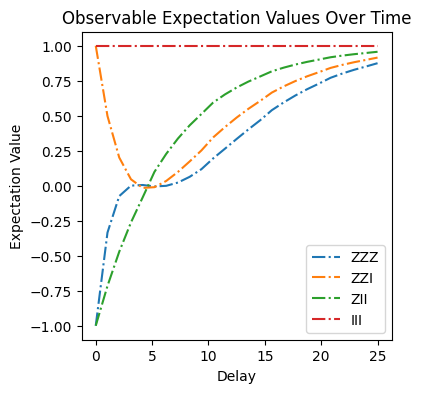

In [208]:
# Plot the decay for the observables
def plot_observable_decay(
    state, observables, observable_labels, delays, trotter_step_size, T1s, T2s
):
    plt.figure(figsize=(4, 4))
    for label in observable_labels:
        obs = observables[label]
        exp_values = []
        for delay in delays:
            rho_final, _ = multi_qubit_experiment(
                state, delay, trotter_step_size, T1s, T2s
            )
            exp_value = expect(obs, rho_final)
            exp_values.append(exp_value)
        plt.plot(delays, exp_values, "-.", label=label)
    plt.legend()
    plt.xlabel("Delay")
    plt.ylabel("Expectation Value")
    plt.title("Observable Expectation Values Over Time")
    plt.show()


# Generate the observables and their labels
observables, observable_labels = define_observables(N)

# Now call the updated function with labels
plot_observable_decay(
    initial_state,
    observables,
    observable_labels,
    delays,
    trotter_step_size,
    T1s,
    T2s,
)

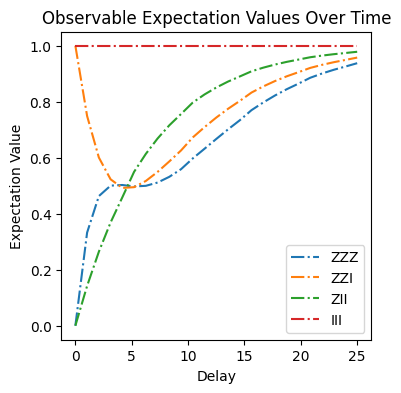

In [209]:
# Now call the updated function with labels
plot_observable_decay(
    ghz_state,
    observables,
    observable_labels,
    delays,
    trotter_step_size,
    T1s,
    T2s,
)